# Visualizing Decision Trees

Nathan A. Mahynski

These are notes on using various tools like [dtreeviz](https://github.com/parrt/dtreeviz) to nicely visualize decision trees.  See their documentation for more examples and up-to-date usage.

In [1]:
using_colab = 'google.colab' in str(get_ipython())
if using_colab:
  from google.colab import drive
  drive.mount('/gdrive')
  root_dir = '/gdrive/MyDrive/Mayan EDMS/Research/Machine Learning/Colab Notebook Examples/visualizing_dt'
else:
  import os
  root_dir = os.getcwd()
  
import matplotlib.pyplot as plt
import numpy as np
import os

import sklearn

MessageError: ignored

In [ ]:
!pip install watermark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install -q dtreeviz==1.3.7 # This is for sklearn

# dtreeviz needs the pip version of graphiviz NOT the conda ones, so you might need to uninstall
# !conda uninstall python-graphviz
# !conda uninstall graphviz

# These are optional for other packages besides sklearn
# !pip install dtreeviz[xgboost]    # install XGBoost related dependency
# !pip install dtreeviz[pyspark]    # install pyspark related dependency
# !pip install dtreeviz[lightgbm]   # install LightGBM related dependency

import dtreeviz

In [ ]:
import watermark
%load_ext watermark

%watermark -t -m -v --iversions

Python implementation: CPython
Python version       : 3.7.13
IPython version      : 5.5.0

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.188+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

pandas    : 1.3.5
IPython   : 5.5.0
graphviz  : 0.10.1
matplotlib: 3.2.2
numpy     : 1.21.6
sklearn   : 0.0
watermark : 2.3.1
google    : 2.0.3
dtreeviz  : 1.3.7



In [ ]:
%matplotlib inline

# Using [scikit-learn](https://scikit-learn.org/)

See sklearn's [documentation](https://scikit-learn.org/stable/modules/tree.html) on visualizing decision trees.

A more [detailed example](https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html#sphx-glr-auto-examples-tree-plot-unveil-tree-structure-py) illustrates things like looking over decision paths.

In [ ]:
from sklearn.datasets import load_iris
from sklearn import tree
iris = load_iris()
X, y = iris.data, iris.target
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, y)

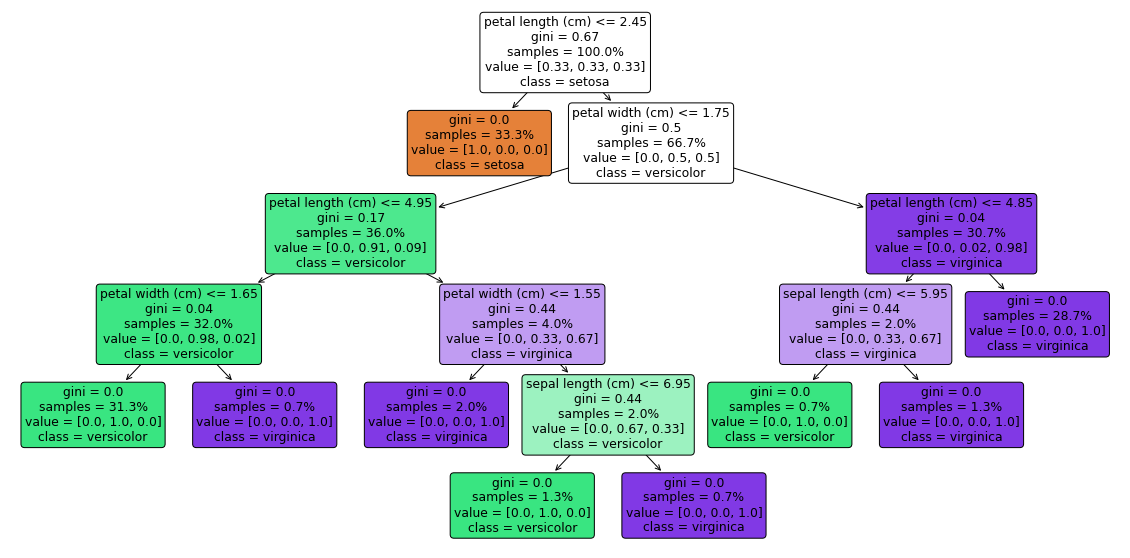

In [ ]:
fig = plt.figure(figsize=(20,10))
_ = tree.plot_tree(
    clf,
    feature_names=iris.feature_names,
    class_names=iris.target_names,
    filled=True,
    proportion=True,
    rounded=True,
    precision=2,
    ax=plt.gca()
    )

In [ ]:
n_nodes = clf.tree_.node_count
children_left = clf.tree_.children_left
children_right = clf.tree_.children_right
feature = clf.tree_.feature
threshold = clf.tree_.threshold

node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
while len(stack) > 0:
    # `pop` ensures each node is only visited once
    node_id, depth = stack.pop()
    node_depth[node_id] = depth

    # If the left and right child of a node is not the same we have a split
    # node
    is_split_node = children_left[node_id] != children_right[node_id]
    # If a split node, append left and right children and depth to `stack`
    # so we can loop through them
    if is_split_node:
        stack.append((children_left[node_id], depth + 1))
        stack.append((children_right[node_id], depth + 1))
    else:
        is_leaves[node_id] = True

print(
    "The binary tree structure has {n} nodes and has "
    "the following tree structure:\n".format(n=n_nodes)
)
for i in range(n_nodes):
    if is_leaves[i]:
        print(
            "{space}node={node} is a leaf node.".format(
                space=node_depth[i] * "\t", node=i
            )
        )
    else:
        print(
            "{space}node={node} is a split node: "
            "go to node {left} if X[:, {feature}] <= {threshold} "
            "else to node {right}.".format(
                space=node_depth[i] * "\t",
                node=i,
                left=children_left[i],
                feature=feature[i],
                threshold=threshold[i],
                right=children_right[i],
            )
        )

The binary tree structure has 17 nodes and has the following tree structure:

node=0 is a split node: go to node 1 if X[:, 2] <= 2.449999988079071 else to node 2.
	node=1 is a leaf node.
	node=2 is a split node: go to node 3 if X[:, 3] <= 1.75 else to node 12.
		node=3 is a split node: go to node 4 if X[:, 2] <= 4.950000047683716 else to node 7.
			node=4 is a split node: go to node 5 if X[:, 3] <= 1.6500000357627869 else to node 6.
				node=5 is a leaf node.
				node=6 is a leaf node.
			node=7 is a split node: go to node 8 if X[:, 3] <= 1.550000011920929 else to node 9.
				node=8 is a leaf node.
				node=9 is a split node: go to node 10 if X[:, 0] <= 6.949999809265137 else to node 11.
					node=10 is a leaf node.
					node=11 is a leaf node.
		node=12 is a split node: go to node 13 if X[:, 2] <= 4.8500001430511475 else to node 16.
			node=13 is a split node: go to node 14 if X[:, 0] <= 5.950000047683716 else to node 15.
				node=14 is a leaf node.
				node=15 is a leaf node.
			node

## Prediction Path

In [ ]:
# Choose a point to analyze
X_test = X[:1]

node_indicator = clf.decision_path(X_test)
leaf_id = clf.apply(X_test)

sample_id = 0
# obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
node_index = node_indicator.indices[
    node_indicator.indptr[sample_id] : node_indicator.indptr[sample_id + 1]
]

print("Rules used to predict sample {id}:\n".format(id=sample_id))
for node_id in node_index:
    # continue to the next node if it is a leaf node
    if leaf_id[sample_id] == node_id:
        continue

    # check if value of the split feature for sample 0 is below threshold
    if X_test[sample_id, feature[node_id]] <= threshold[node_id]:
        threshold_sign = "<="
    else:
        threshold_sign = ">"

    print(
        "decision node {node} : (X_test[{sample}, {feature}] = {value}) "
        "{inequality} {threshold})".format(
            node=node_id,
            sample=sample_id,
            feature=feature[node_id],
            value=X_test[sample_id, feature[node_id]],
            inequality=threshold_sign,
            threshold=threshold[node_id],
        )
    )

Rules used to predict sample 0:

decision node 0 : (X_test[0, 2] = 1.4) <= 2.449999988079071)


In [ ]:
sample_ids = [0, 1]
# boolean array indicating the nodes both samples go through
common_nodes = node_indicator.toarray()[sample_ids].sum(axis=0) == len(sample_ids)
# obtain node ids using position in array
common_node_id = np.arange(n_nodes)[common_nodes]

print(
    "\nThe following samples {samples} share the node(s) {nodes} in the tree.".format(
        samples=sample_ids, nodes=common_node_id
    )
)
print("This is {prop}% of all nodes.".format(prop=100 * len(common_node_id) / n_nodes))


The following samples [0, 1] share the node(s) [0 1] in the tree.
This is 11.764705882352942% of all nodes.


## Decision Boundaries

In [ ]:
from sklearn.inspection import DecisionBoundaryDisplay 

# Parameters
n_classes = 3
plot_colors = "ryb"
plot_step = 0.02


for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]]):
    # We only take the two corresponding features
    X = iris.data[:, pair]
    y = iris.target

    # Train
    clf = DecisionTreeClassifier().fit(X, y)

    # Plot the decision boundary
    ax = plt.subplot(2, 3, pairidx + 1)
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)
    DecisionBoundaryDisplay.from_estimator(
        clf,
        X,
        cmap=plt.cm.RdYlBu,
        response_method="predict",
        ax=ax,
        xlabel=iris.feature_names[pair[0]],
        ylabel=iris.feature_names[pair[1]],
    )

    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(
            X[idx, 0],
            X[idx, 1],
            c=color,
            label=iris.target_names[i],
            cmap=plt.cm.RdYlBu,
            edgecolor="black",
            s=15,
        )

plt.suptitle("Decision surface of decision trees trained on pairs of features")
plt.legend(loc="lower right", borderpad=0, handletextpad=0)
_ = plt.axis("tight")

ImportError: ignored

In [ ]:
n_nodes = clf.tree_.node_count
children_left = clf.tree_.children_left
children_right = clf.tree_.children_right
feature = clf.tree_.feature
threshold = clf.tree_.threshold

node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
while len(stack) > 0:
    # `pop` ensures each node is only visited once
    node_id, depth = stack.pop()
    node_depth[node_id] = depth

    # If the left and right child of a node is not the same we have a split
    # node
    is_split_node = children_left[node_id] != children_right[node_id]
    # If a split node, append left and right children and depth to `stack`
    # so we can loop through them
    if is_split_node:
        stack.append((children_left[node_id], depth + 1))
        stack.append((children_right[node_id], depth + 1))
    else:
        is_leaves[node_id] = True

print(
    "The binary tree structure has {n} nodes and has "
    "the following tree structure:\n".format(n=n_nodes)
)
for i in range(n_nodes):
    if is_leaves[i]:
        print(
            "{space}node={node} is a leaf node.".format(
                space=node_depth[i] * "\t", node=i
            )
        )
    else:
        print(
            "{space}node={node} is a split node: "
            "go to node {left} if X[:, {feature}] <= {threshold} "
            "else to node {right}.".format(
                space=node_depth[i] * "\t",
                node=i,
                left=children_left[i],
                feature=feature[i],
                threshold=threshold[i],
                right=children_right[i],
            )
        )

The binary tree structure has 93 nodes and has the following tree structure:

node=0 is a split node: go to node 1 if X[:, 0] <= 5.450000047683716 else to node 14.
	node=1 is a split node: go to node 2 if X[:, 1] <= 2.8000000715255737 else to node 9.
		node=2 is a split node: go to node 3 if X[:, 0] <= 4.700000047683716 else to node 4.
			node=3 is a leaf node.
			node=4 is a split node: go to node 5 if X[:, 0] <= 4.950000047683716 else to node 8.
				node=5 is a split node: go to node 6 if X[:, 1] <= 2.450000047683716 else to node 7.
					node=6 is a leaf node.
					node=7 is a leaf node.
				node=8 is a leaf node.
		node=9 is a split node: go to node 10 if X[:, 0] <= 5.3500001430511475 else to node 11.
			node=10 is a leaf node.
			node=11 is a split node: go to node 12 if X[:, 1] <= 3.200000047683716 else to node 13.
				node=12 is a leaf node.
				node=13 is a leaf node.
	node=14 is a split node: go to node 15 if X[:, 0] <= 6.1499998569488525 else to node 52.
		node=15 is a split n

# Using [dtreeviz](https://github.com/parrt/dtreeviz)

You can read more about this package and why design decisions were made [here](https://explained.ai/decision-tree-viz/index.html)

In [ ]:
from sklearn import tree
from sklearn.datasets import load_boston, load_iris, load_diabetes

In [ ]:
from dtreeviz.trees import *

In [ ]:
?dtreeviz

## Regression

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

<IPython.core.display.Javascript object>

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

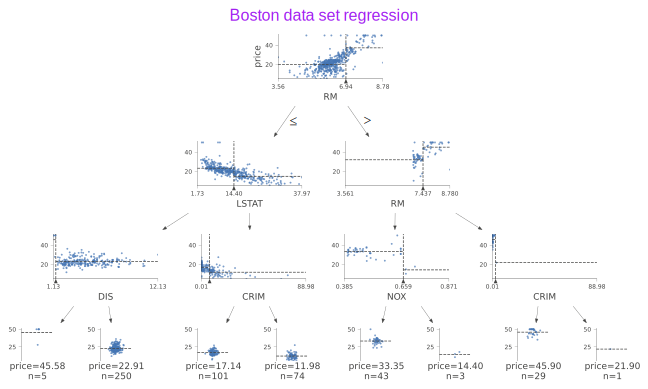

In [ ]:
regr = tree.DecisionTreeRegressor(max_depth=3)
boston = load_boston()

X_train = boston.data
y_train = boston.target
regr.fit(X_train, y_train)

viz = dtreeviz(regr,
               X_train,
               y_train,
               target_name='price',  # this name will be displayed at the leaf node
               feature_names=boston.feature_names,
               title="Boston data set regression",
               fontname="Arial",
               title_fontsize=16,
               colors = {"title":"purple"}
              )
viz
# viz.view() will give give a popup with graph in pdf

## Classification

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

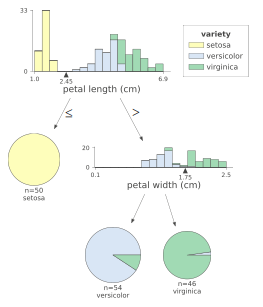

In [ ]:
classifier = tree.DecisionTreeClassifier(max_depth=2)  # limit depth of tree
iris = load_iris()
classifier.fit(iris.data, iris.target)

viz = dtreeviz(classifier, 
               iris.data, 
               iris.target,
               target_name='variety',
               feature_names=iris.feature_names, 
               class_names=["setosa", "versicolor", "virginica"]  # need class_names for classifier
              ) 

viz 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

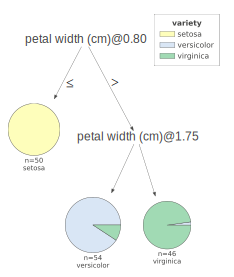

In [ ]:
classifier = tree.DecisionTreeClassifier(max_depth=2)  # limit depth of tree
iris = load_iris()
classifier.fit(iris.data, iris.target)

viz = dtreeviz(classifier, 
               iris.data, 
               iris.target,
               target_name='variety',
               feature_names=iris.feature_names, 
               class_names=["setosa", "versicolor", "virginica"],  
               fancy=False # fancy=False to remove histograms/scatterplots from decision nodes
              ) 

viz 

## Prediction Path

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

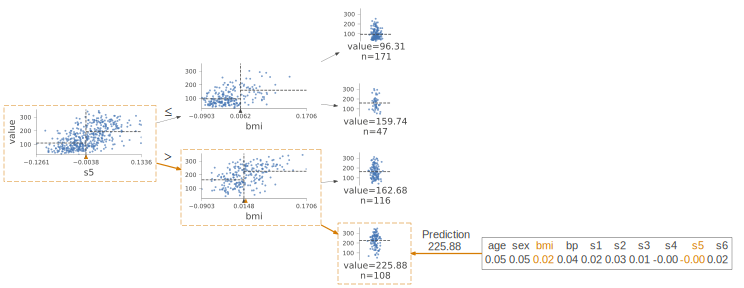

In [ ]:
# Highlights the decision nodes in which the feature value of single observation 
# passed in argument X falls. Gives feature values of the observation and 
# highlights features which are used by tree to traverse path.

regr = tree.DecisionTreeRegressor(max_depth=2)  # limit depth of tree
diabetes = load_diabetes()
regr.fit(diabetes.data, diabetes.target)
X = diabetes.data[np.random.randint(0, len(diabetes.data)),:]  # random sample from training

viz = dtreeviz(regr,
               diabetes.data, 
               diabetes.target, 
               target_name='value', 
               orientation ='LR',  # left-right orientation
               feature_names=diabetes.feature_names,
               X=X)  # need to give single observation for prediction
              
viz

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

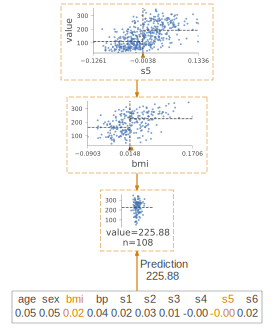

In [ ]:
dtreeviz(regr,
        diabetes.data, 
        diabetes.target, 
        target_name='value', 
        orientation ='TD',  # top-down orientation
        feature_names=diabetes.feature_names,
        X=X, # need to give single observation for prediction
        show_just_path=True     
        )

In [ ]:
print(explain_prediction_path(regr, X, feature_names=diabetes.feature_names, 
                              explanation_type="plain_english"))

0.01 <= bmi 
s5 < -0.0



In [ ]:
plt.figure()
print(explain_prediction_path(regr, X, feature_names=diabetes.feature_names, 
                              explanation_type="sklearn_default"))
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

AxesSubplot(0.125,0.125;0.775x0.755)


## Feature-target space

### Regression

In [ ]:
output = os.path.join(root_dir, "cars.csv")

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  "X does not have valid feature names, but"


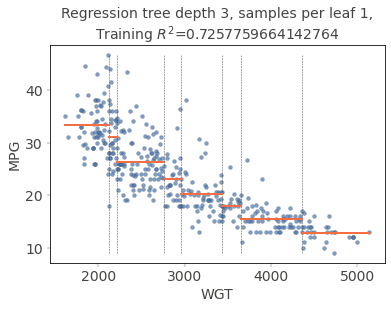

In [ ]:
# Regression univariate feature-target space

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor

df_cars = pd.read_csv(output)
X, y = df_cars[['WGT']], df_cars['MPG']

dt = DecisionTreeRegressor(max_depth=3, criterion="absolute_error")
dt.fit(X, y)

fig = plt.figure()
ax = fig.gca()
rtreeviz_univar(dt, X, y, feature_names='WGT', target_name='MPG', ax=ax)
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  "X does not have valid feature names, but"


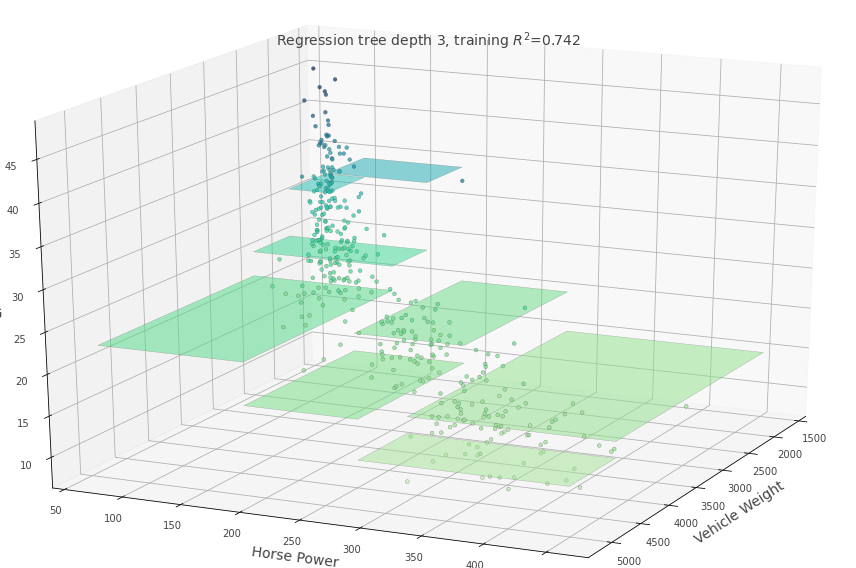

In [ ]:
# Regression bivariate feature-target space

from mpl_toolkits.mplot3d import Axes3D
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *

df_cars = pd.read_csv(output)
X = df_cars[['WGT','ENG']]
y = df_cars['MPG']

dt = DecisionTreeRegressor(max_depth=3, criterion="mae")
dt.fit(X, y)

figsize = (12,8)
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111, projection='3d')

t = rtreeviz_bivar_3D(dt,
                      X, y,
                      feature_names=['Vehicle Weight', 'Horse Power'],
                      target_name='MPG',
                      fontsize=14,
                      elev=20,
                      azim=25,
                      dist=8.2,
                      show={'splits','title'},
                      ax=ax)
plt.tight_layout()

/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  "X does not have valid feature names, but"


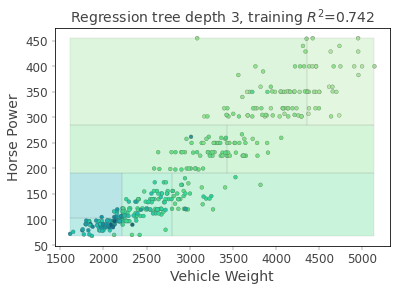

In [ ]:
# Regression bivariate feature-target space heatmap

from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *

df_cars = pd.read_csv(output)
X = df_cars[['WGT','ENG']]
y = df_cars['MPG']

dt = DecisionTreeRegressor(max_depth=3, criterion="mae")
dt.fit(X, y)

t = rtreeviz_bivar_heatmap(dt,
                           X, y,
                           feature_names=['Vehicle Weight', 'Horse Power'],
                           fontsize=14)

plt.show()

### Classification

In [ ]:
output = os.path.join(root_dir, "knowledge.csv")

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"


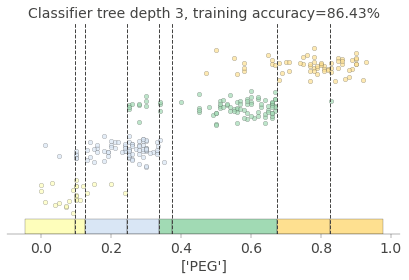

In [ ]:
# Classification univariate feature-target space

from sklearn.tree import DecisionTreeClassifier
from dtreeviz.trees import *

know = pd.read_csv(output)
class_names = ['very_low', 'Low', 'Middle', 'High']
know['UNS'] = know['UNS'].map({n: i for i, n in enumerate(class_names)})

X = know[['PEG']]
y = know['UNS']

dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X, y)

ct = ctreeviz_univar(dt, X, y,
                     feature_names = ['PEG'],
                     class_names=class_names,
                     target_name='Knowledge',
                     nbins=40, gtype='strip',
                     show={'splits','title'})
plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


      STG   SCG   STR   LPR   PEG       UNS
0    0.00  0.00  0.00  0.00  0.00  very_low
1    0.08  0.08  0.10  0.24  0.90      High
2    0.06  0.06  0.05  0.25  0.33       Low
3    0.10  0.10  0.15  0.65  0.30    Middle
4    0.08  0.08  0.08  0.98  0.24       Low
..    ...   ...   ...   ...   ...       ...
253  0.61  0.78  0.69  0.92  0.58      High
254  0.78  0.61  0.71  0.19  0.60    Middle
255  0.54  0.82  0.71  0.29  0.77      High
256  0.50  0.75  0.81  0.61  0.26    Middle
257  0.66  0.90  0.76  0.87  0.74      High

[258 rows x 6 columns]


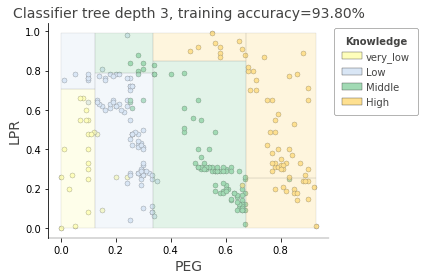

In [ ]:
# Classification bivariate feature-target space

from sklearn.tree import DecisionTreeClassifier
from dtreeviz.trees import *

know = pd.read_csv(output)
print(know)
class_names = ['very_low', 'Low', 'Middle', 'High']
know['UNS'] = know['UNS'].map({n: i for i, n in enumerate(class_names)})

X = know[['PEG','LPR']]
y = know['UNS']

dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X, y)

ct = ctreeviz_bivar(dt, X, y,
                    feature_names = ['PEG','LPR'],
                    class_names=class_names,
                    target_name='Knowledge')
plt.tight_layout()
plt.show()